In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [ ]:
train_path = "/content/drive/MyDrive/Kidney Stone Detection_AIML/kaggle/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/train"
test_path = "/content/drive/MyDrive/Kidney Stone Detection_AIML/kaggle/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/test"
valid_path = "/content/drive/MyDrive/Kidney Stone Detection_AIML/kaggle/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/valid"

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=12 )

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=12)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 6097 images belonging to 4 classes.
Found 2030 images belonging to 4 classes.
Found 2032 images belonging to 4 classes.


In [ ]:
base_model=tf.keras.applications.MobileNetV2()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.layers[-5].output
x = tf.keras.layers.GlobalMaxPool2D()(x)
output = Dense(units=4, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,988 (8.61 MB)

 Trainable params: 1,362,564 (5.20 MB)

 Non-trainable params: 895,424 (3.42 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define early stopping to monitor validation accuracy and set patience
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=6, verbose=1)

# Define model checkpoint to save the best model based on validation accuracy
mc = ModelCheckpoint(filepath='MobileNetV2_best.keras', monitor='val_accuracy', verbose=1, save_best_only=True)

# Combine the callbacks
cb = [mc, es]

In [ ]:
history = model.fit(x=train_batches,
                    validation_data=valid_batches,
                    callbacks = cb,
                    epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8458 - loss: 0.7224
Epoch 1: val_accuracy improved from -inf to 0.76502, saving model to MobileNetV2_best.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 2255s 4s/step - accuracy: 0.8460 - loss: 0.7218 - val_accuracy: 0.7650 - val_loss: 3.1669
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9413 - loss: 0.2718
Epoch 2: val_accuracy improved from 0.76502 to 0.89704, saving model to MobileNetV2_best.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.9413 - loss: 0.2716 - val_accuracy: 0.8970 - val_loss: 1.0332
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.9671 - loss: 0.1764
Epoch 3: val_accuracy did not improve from 0.89704
509/509 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.9671 - loss: 0.1766 - val_accuracy: 0.5034 - val_loss: 43.9799
Epoch 4/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9741 - loss: 0.1228
Epoch 4: val_accuracy improved from 0.89704 to 0.99212, saving model

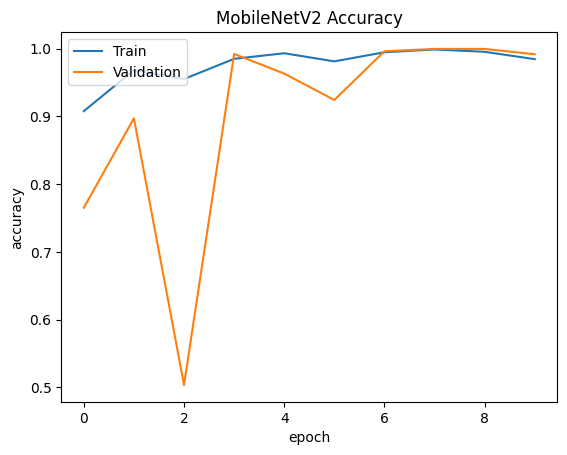

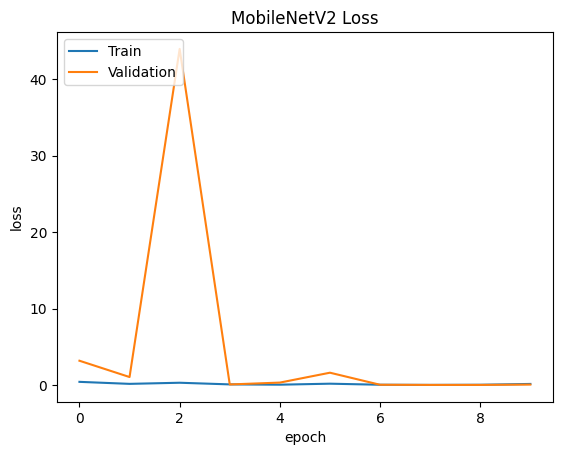

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNetV2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# load model
model1 = load_model('MobileNetV2_best.keras')

In [ ]:
test_labels = test_batches.classes
print(test_labels)

[0 0 0 ... 2 2 2]


In [ ]:
pred = model1.predict(x=test_batches)

407/407 ━━━━━━━━━━━━━━━━━━━━ 117s 264ms/step


In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=pred.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

In [ ]:
def plot_cm(cm, classes,
            normalize=False, title='Confusion Matrix',
            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment = 'center', color = "white" if cm[i,j]> thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalization
[[ 742    0    0]
 [   0 1014    1]
 [   2    0  273]]


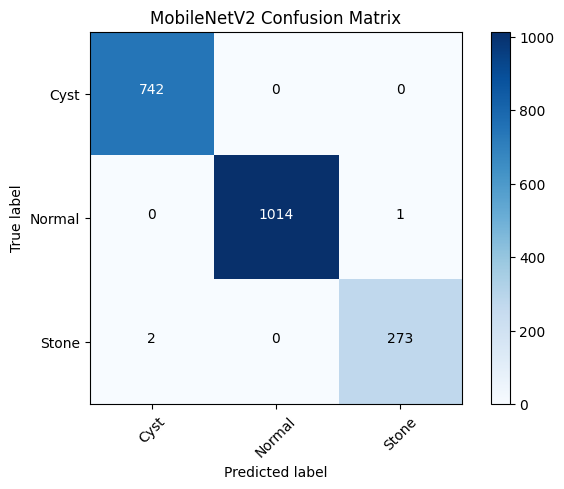

In [ ]:
cm_plot_labels=["Cyst", "Normal","Stone"]
plot_cm(cm=cm, classes=cm_plot_labels, title = 'MobileNetV2 Confusion Matrix')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print("MobileNetV2 Classification Report: \n", classification_report(y_true=test_labels, y_pred=pred.argmax(axis=1)))

MobileNetV2 Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       742
           1       1.00      1.00      1.00      1015
           2       1.00      0.99      0.99       275

    accuracy                           1.00      2032
   macro avg       1.00      1.00      1.00      2032
weighted avg       1.00      1.00      1.00      2032



In [ ]:
from sklearn.metrics import accuracy_score

print(100*accuracy_score(test_labels, pred.argmax(axis=1)))

99.85236220472441
